In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
#%% Objective
'''
Objective: Build a Lasso model for the Kaggle House Prices competition.

Pipeline:
1.  **Setup & Data Loading:**
    *   Import libraries, load datasets (`train.csv`, `test.csv`).
    *   Prepare IDs and initial data views.
    *   Create output directories.
2.  **Data Preprocessing:**
    *   Store and log-transform `SalePrice` (target variable).
    *   Merge train and test sets, adding a 'source' column for tracking.
    *   Drop specified columns (`MoSold`, `YrSold`) and columns with >50% missing values.
    *   Perform feature engineering and select model features, then identify numerical and categorical columns.
    *   Build and apply preprocessing pipelines with `ColumnTransformer`
3.  **Model Training (Lasso Regression):**
    *   Train a Lasso regression model.
    *   Use `GridSearchCV` to tune the `alpha` hyperparameter, optimizing for `neg_mean_squared_error`.
    *   Plot and save the learning curve for the best model.
4.  **Evaluation & Submission:**
    *   Generate `submission.csv` with `Id` and `SalePrice`.
'''


"\nObjective: Build a Lasso model for the Kaggle House Prices competition.\n\nPipeline:\n1.  **Setup & Data Loading:**\n    *   Import libraries, load datasets (`train.csv`, `test.csv`).\n    *   Prepare IDs and initial data views.\n    *   Create output directories.\n2.  **Data Preprocessing:**\n    *   Store and log-transform `SalePrice` (target variable).\n    *   Merge train and test sets, adding a 'source' column for tracking.\n    *   Drop specified columns (`MoSold`, `YrSold`) and columns with >50% missing values.\n    *   Perform feature engineering and select model features, then identify numerical and categorical columns.\n    *   Build and apply preprocessing pipelines with `ColumnTransformer`\n3.  **Model Training (Lasso Regression):**\n    *   Train a Lasso regression model.\n    *   Use `GridSearchCV` to tune the `alpha` hyperparameter, optimizing for `neg_mean_squared_error`.\n    *   Plot and save the learning curve for the best model.\n4.  **Evaluation & Submission:**\

In [3]:
#%% Step 1: Project Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import joblib # For potential model saving
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import os

# Create output directories
os.makedirs("output/charts", exist_ok=True)

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load data
try:
    train_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
    test_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
    sample_submission_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/sample_submission.csv')
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Ensure train.csv, test.csv, and sample_submission.csv are in 'Kaggle_housing/data/'.")
    raise

# Store IDs for submission
train_id = train_df['Id']
test_id = test_df['Id']

# Drop ID columns from training and test dataframes
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

print("Data loaded successfully.")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")


Data loaded successfully.
Training data shape: (1460, 80)
Test data shape: (1459, 79)


In [19]:
# Apply outlier filtering using quantiles and logical AND operator
train_df = train_df[
    (train_df['GrLivArea'] < train_df['GrLivArea'].quantile(0.95)) &
    (train_df['TotalBsmtSF'] < train_df['TotalBsmtSF'].quantile(0.95)) &  # Changed to use TotalSF's quantile
    (train_df['GarageArea'] < train_df['GarageArea'].quantile(0.95)) &
    (train_df['LotArea'] < train_df['LotArea'].quantile(0.90)) &
    (train_df['YearBuilt'] > 1880)  # Changed to logical > operator (houses built AFTER 1880)
]

In [12]:
# %% Step 3: Data Preprocessing (Refactored with sklearn Pipelines)

# 3.1. Store SalePrice, merge train/test for consistent preprocessing
target = train_df['SalePrice'].copy()
train_df_temp = train_df.drop('SalePrice', axis=1)
train_df_temp['source'] = 'train'
test_df['source'] = 'test'
combined_df = pd.concat([train_df_temp, test_df], ignore_index=True, sort=False)

# 3.2. Drop specified columns and those with >50% NaN values
#columns_to_drop_readme = ['MoSold', 'YrSold']
#combined_df = combined_df.drop(columns=columns_to_drop_readme)
missing_percentage = combined_df.isnull().sum() * 100 / len(combined_df)
columns_to_drop_missing = missing_percentage[missing_percentage > 50].index
combined_df = combined_df.drop(columns=columns_to_drop_missing)

# 3.3. Custom Transformations
# Convert MSSubClass to string (categorical identifier)
if 'MSSubClass' in combined_df.columns:
    combined_df['MSSubClass'] = combined_df['MSSubClass'].astype(str)

# Ordinal map KitchenQual. Mapped feature will be handled by numerical imputer.
quality_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
if 'KitchenQual' in combined_df.columns:
    combined_df['KitchenQual'] = combined_df['KitchenQual'].map(quality_map)
if 'HeatingQC' in combined_df.columns:
    combined_df['HeatingQC'] = combined_df['HeatingQC'].map(quality_map)
if 'FireplaceQu' in combined_df.columns:
    combined_df['FireplaceQu'] = combined_df['FireplaceQu'].map(quality_map)
if 'ExterQual' in combined_df.columns:
    combined_df['ExterQual'] = combined_df['ExterQual'].map(quality_map)
if 'GarageQual' in combined_df.columns:
    combined_df['GarageQual'] = combined_df['GarageQual'].map(quality_map)

combined_df['HouseAge'] = combined_df['YrSold'] - combined_df['YearBuilt']
combined_df['RenovateAge']=combined_df['YrSold'] - combined_df['YearRemodAdd']
combined_df['TotalSF'] =combined_df['GrLivArea'] + combined_df['TotalBsmtSF']

# Create ProximityConditions feature from Condition1 and Condition2
def merge_conditions(row):
    cond1 = str(row['Condition1'])
    cond2 = str(row['Condition2'])
    conditions = set()
    if cond1 != 'Norm' and pd.notna(cond1):
        conditions.add(cond1)
    if cond2 != 'Norm' and pd.notna(cond2):
        conditions.add(cond2)
    if not conditions:
        return 'Norm'
    return '_'.join(sorted(list(conditions)))

if 'Condition1' in combined_df.columns and 'Condition2' in combined_df.columns:
    combined_df['ProximityConditions'] = combined_df.apply(merge_conditions, axis=1)
    combined_df = combined_df.drop(columns=['Condition1', 'Condition2'], errors='ignore')

# 3.4. Feature Selection for Pipeline Input
selected_features_for_pipeline = [
    # Location/Structure
    'Neighborhood', 'MSZoning', 'MSSubClass', 'BldgType', 'HouseStyle',
    
    # Quality/Condition
    'OverallQual', 'HeatingQC', 'KitchenQual',
    
    # Size/Area
    'TotalSF', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'LotArea', 
    
    # Rooms/Bath
    'FullBath', 'TotalRmsAbvGrd',
    
    # Temporal
    'RenovateAge', 'HouseAge', 'MoSold',
    
    # Engineered
    'ProximityConditions' # New categorical feature
]


# Filter combined_df to selected features + 'source' for splitting
columns_to_keep_in_combined = selected_features_for_pipeline + ['source']
actual_columns_to_keep = [col for col in columns_to_keep_in_combined if col in combined_df.columns]
if len(actual_columns_to_keep) != len(columns_to_keep_in_combined):
    missing_cols = set(columns_to_keep_in_combined) - set(actual_columns_to_keep)
    print(f"Warning: Selected features not in combined_df and will be skipped: {missing_cols}")
combined_df = combined_df[actual_columns_to_keep]


# 3.5. Define Numerical and Categorical Columns for ColumnTransformer
numerical_cols_pipeline = combined_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols_pipeline = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()

# 'source' is for splitting, not modeling
if 'source' in categorical_cols_pipeline:
    categorical_cols_pipeline.remove('source')
if 'source' in numerical_cols_pipeline: # Safeguard
    numerical_cols_pipeline.remove('source')

# 3.6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3.7. Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_pipeline),
        ('cat', categorical_pipeline, categorical_cols_pipeline)
    ],
    remainder='drop' # Drops columns not specified (e.g. 'source')
)

target_log = target
# 3.8. Target Variable Transformation (Log-transform SalePrice)
if 'SalePrice' in target.index:
    target_log = target #np.log1p(target)
else:
    target_log = np.log1p(pd.Series(target, index=train_df.index)) # Should not be hit normally

# 3.9. Split data back and apply preprocessor
X = combined_df.drop('source', axis=1, errors='ignore')
source_col = combined_df['source']

# Ensure X has columns intended for preprocessor
feature_cols_for_preprocessor = numerical_cols_pipeline + categorical_cols_pipeline
X_for_preprocessor = X[feature_cols_for_preprocessor]

# Split X based on 'source'
X_train_features = X_for_preprocessor[source_col == 'train']
X_test_features = X_for_preprocessor[source_col == 'test']

# Fit preprocessor on training data, transform both train and test
preprocessor.fit(X_train_features)
X_train_processed_np = preprocessor.transform(X_train_features)
X_test_processed_np = preprocessor.transform(X_test_features)

# Get feature names after OHE for DataFrame conversion
feature_names_out = preprocessor.get_feature_names_out()
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_out, index=X_train_features.index)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_out, index=X_test_features.index)

# Consolidated output for Step 3
print(f"--- Step 3: Data Preprocessing Complete ---")
print(f"Processed X_train shape: {X_train_processed.shape}, Processed X_test shape: {X_test_processed.shape}")
print(f"First 3 rows of X_train_processed:\n{X_train_processed.head(3).to_string()}")


--- Step 3: Data Preprocessing Complete ---
Processed X_train shape: (1460, 83), Processed X_test shape: (1459, 83)
First 3 rows of X_train_processed:
   num__OverallQual  num__HeatingQC  num__KitchenQual  num__TotalSF  num__GrLivArea  num__TotalBsmtSF  num__GarageArea  num__LotArea  num__FullBath  num__RenovateAge  num__HouseAge  num__MoSold  cat__Neighborhood_Blmngtn  cat__Neighborhood_Blueste  cat__Neighborhood_BrDale  cat__Neighborhood_BrkSide  cat__Neighborhood_ClearCr  cat__Neighborhood_CollgCr  cat__Neighborhood_Crawfor  cat__Neighborhood_Edwards  cat__Neighborhood_Gilbert  cat__Neighborhood_IDOTRR  cat__Neighborhood_MeadowV  cat__Neighborhood_Mitchel  cat__Neighborhood_NAmes  cat__Neighborhood_NPkVill  cat__Neighborhood_NWAmes  cat__Neighborhood_NoRidge  cat__Neighborhood_NridgHt  cat__Neighborhood_OldTown  cat__Neighborhood_SWISU  cat__Neighborhood_Sawyer  cat__Neighborhood_SawyerW  cat__Neighborhood_Somerst  cat__Neighborhood_StoneBr  cat__Neighborhood_Timber  cat__Neighborho

In [14]:
print(f"X shape: {X_train_processed.shape}")
print(f"y shape: {target_log.shape}")

X shape: (1460, 83)
y shape: (1460,)


Fitting 5 folds for each of 101 candidates, totalling 505 fits
--- Step 4: Model Training Results ---
Best Ridge alpha: 3.2586999999999997
Best CV RMSE (on log-transformed SalePrice): 0.1518

Plotting Learning Curve...
Learning curve saved to output/charts/learning_curve_ridge.png


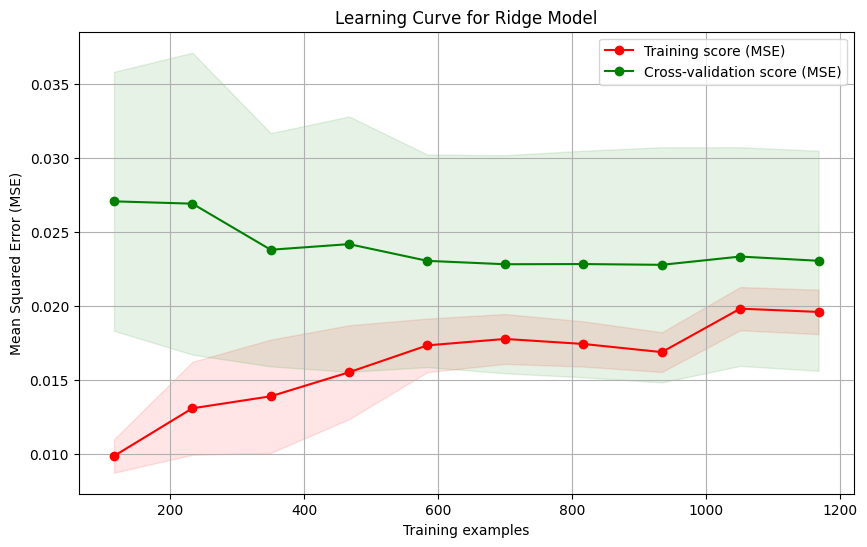

In [15]:
# %% Step 4: Model Training (Ridge)
# Lasso Regression with GridSearchCV for hyperparameter tuning

from sklearn.linear_model import Ridge
model_1 = Pipeline([
    ('ridge', Ridge())
])


# define set of params values
pipe_params = {
    "ridge__alpha": list(np.linspace(0.01, 25, 101))}


# Use neg_mean_squared_error as target is log-transformed (~RMSLE for original target)
grid_search = GridSearchCV(model_1, pipe_params, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs = -1, verbose=1)
grid_search.fit(X_train_processed, target_log)

best_ridge_model = grid_search.best_estimator_

# RMSE on log-transformed target
best_cv_rmse = np.sqrt(-grid_search.best_score_)

# Consolidated output for Step 4 Model Training Results
print(f"--- Step 4: Model Training Results ---")
print(f"Best Ridge alpha: {best_ridge_model.named_steps['ridge'].alpha}")
print(f"Best CV RMSE (on log-transformed SalePrice): {best_cv_rmse:.4f}")

# Plot Learning Curve for the best model
print("\nPlotting Learning Curve...")
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_ridge_model, X_train_processed, target_log, cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std for scores (scores are negative MSE)
train_scores_mean = -np.mean(train_scores_lc, axis=1)
train_scores_std = np.std(train_scores_lc, axis=1)
test_scores_mean = -np.mean(test_scores_lc, axis=1)
test_scores_std = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score (MSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score (MSE)")

plt.title("Learning Curve for Ridge Model")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend(loc="best")
plt.grid(True)
plt.savefig("output/charts/learning_curve_ridge.png")
print("Learning curve saved to output/charts/learning_curve_ridge.png")
# plt.show() # Optional: display plot interactively


In [37]:
import sklearn
sklearn.metrics.get_scorer_names()


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

Fitting 5 folds for each of 101 candidates, totalling 505 fits
--- Step 4: Model Training Results ---
Best Lasso alpha: 0.001
Best CV RMSE (on log-transformed SalePrice): 0.1534

Plotting Learning Curve...
Learning curve saved to output/charts/learning_curve_lasso.png


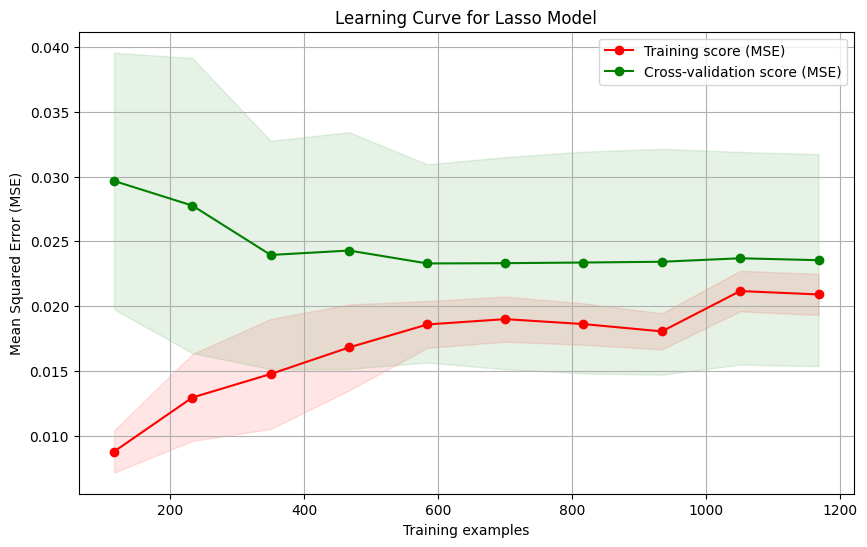

In [38]:
# %% Step 4: Model Training (Lasso)
# Lasso Regression with GridSearchCV for hyperparameter tuning

from sklearn.linear_model import Ridge
model_1 = Pipeline([
    ('lasso', Lasso())
])


# define set of params values
pipe_params = {
    "lasso__alpha": list(np.linspace(0.001, 25, 101))}


# Use neg_mean_squared_error as target is log-transformed (~RMSLE for original target)
grid_search = GridSearchCV(model_1, pipe_params, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs = -1, verbose=1)
grid_search.fit(X_train_processed, target_log)

best_lasso_model = grid_search.best_estimator_

# RMSE on log-transformed target
best_cv_rmse = np.sqrt(-grid_search.best_score_)

# Consolidated output for Step 4 Model Training Results
print(f"--- Step 4: Model Training Results ---")
print(f"Best Lasso alpha: {best_lasso_model.named_steps['lasso'].alpha}")
print(f"Best CV RMSE (on log-transformed SalePrice): {best_cv_rmse:.4f}")

# Plot Learning Curve for the best model
print("\nPlotting Learning Curve...")
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_lasso_model, X_train_processed, target_log, cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std for scores (scores are negative MSE)
train_scores_mean = -np.mean(train_scores_lc, axis=1)
train_scores_std = np.std(train_scores_lc, axis=1)
test_scores_mean = -np.mean(test_scores_lc, axis=1)
test_scores_std = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score (MSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score (MSE)")

plt.title("Learning Curve for Lasso Model")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend(loc="best")
plt.grid(True)
plt.savefig("output/charts/learning_curve_lasso.png")
print("Learning curve saved to output/charts/learning_curve_lasso.png")
# plt.show() # Optional: display plot interactively


Ridge and Lasso model seems underfitting. However in the learning curve, using single training set, the performance is worse than the peak. The data may be the issue here

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
--- Step 4: Model Training Results ---
Best XGB parameters:
  n_estimators: 400
  max_depth: 4
  learning_rate: 0.05
  min_child_weight: 3
Best CV RMSE (on log-transformed SalePrice): 0.1335

Plotting Learning Curve...
Learning curve saved to output/charts/learning_curve_xgb.png


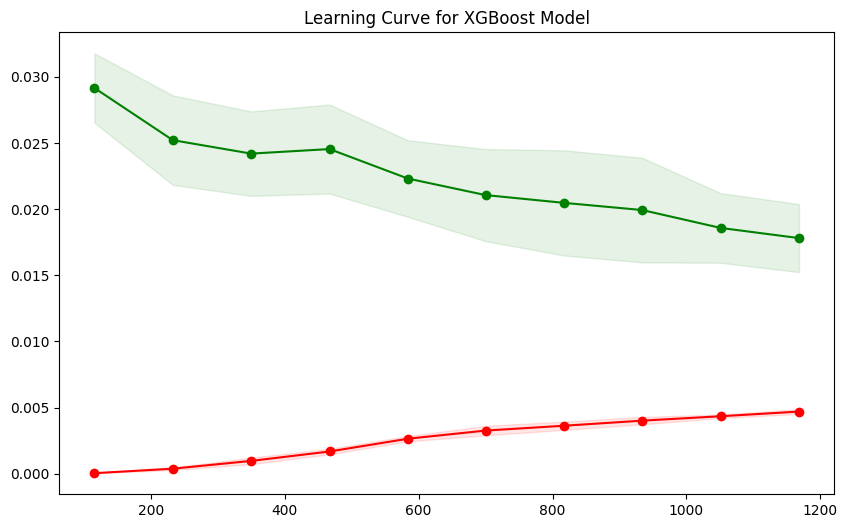

In [48]:
# %% Step 4: Model Training (XGBRegressor)
# XGBoost with GridSearchCV for hyperparameter tuning
from xgboost import XGBRegressor

# build pipeline for all numeric features
model_2 =  Pipeline([
    ('XGB', XGBRegressor())
])

pipe_params = {
    'XGB__n_estimators': [300, 400],
    'XGB__max_depth': [3, 4],
    'XGB__learning_rate': [0.01,0.05, 0.1, 0.2],
    'XGB__min_child_weight': [1,3],
    'XGB__gamma': [0, 0.1, 0.2],
    'XGB__subsample': [0.65, 0.9],
    'XGB__colsample_bytree': [0.5, 0.9],
}

grid_search = GridSearchCV(model_2, pipe_params, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, target_log)

best_xgb_model = grid_search.best_estimator_
best_cv_rmse = np.sqrt(-grid_search.best_score_)

# Consolidated output for Step 4 Model Training Results
print(f"--- Step 4: Model Training Results ---")
print(f"Best XGB parameters:")
print(f"  n_estimators: {best_xgb_model.named_steps['XGB'].n_estimators}")
print(f"  max_depth: {best_xgb_model.named_steps['XGB'].max_depth}")
print(f"  learning_rate: {best_xgb_model.named_steps['XGB'].learning_rate}")
print(f"  min_child_weight: {best_xgb_model.named_steps['XGB'].min_child_weight}")

print(f"Best CV RMSE (on log-transformed SalePrice): {best_cv_rmse:.4f}")

# Plot Learning Curve for the best model
print("\nPlotting Learning Curve...")
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_xgb_model,  # Changed from best_lasso_model
    X_train_processed, 
    target_log, 
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# [Keep the rest of the plotting code the same but update titles]
# Calculate mean and std for scores (scores are negative MSE)
train_scores_mean = -np.mean(train_scores_lc, axis=1)
train_scores_std = np.std(train_scores_lc, axis=1)
test_scores_mean = -np.mean(test_scores_lc, axis=1)
test_scores_std = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score (MSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score (MSE)")
plt.title("Learning Curve for XGBoost Model")  # Changed title
plt.savefig("output/charts/learning_curve_xgb.png")  # Changed filename
print("Learning curve saved to output/charts/learning_curve_xgb.png")


Fitting 4 folds for each of 54 candidates, totalling 216 fits
--- Step 4: Model Training Results ---
Best RF parameters:
  n_estimators: 500
  max_depth: 20
  min_samples_split: 2
Best CV RMSE: 0.1436

Plotting Learning Curve...


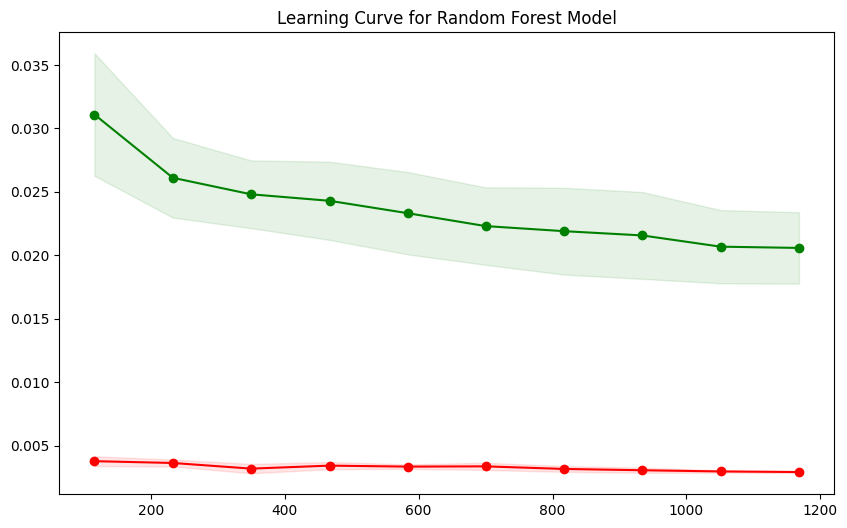

In [40]:
# %% Step 4: Model Training (Random Forest)
from sklearn.ensemble import RandomForestRegressor

# Build pipeline for Random Forest
model_3 = Pipeline([
    ('RF', RandomForestRegressor(random_state=42))  # Changed to RandomForest
])

# Optimized parameter grid for Random Forest
pipe_params = {
    'RF__n_estimators': [100, 200, 500],
    'RF__max_depth': [None, 10, 20],  # None allows full depth
    'RF__min_samples_split': [2, 5, 10],
    'RF__max_features': ['sqrt', 0.8]
}

# Changed to model_3 to match pipeline name
grid_search = GridSearchCV(model_3, pipe_params, cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, target_log)

best_rf_model = grid_search.best_estimator_
best_cv_rmse = np.sqrt(-grid_search.best_score_)

# Correct output for Random Forest parameters
print(f"--- Step 4: Model Training Results ---")
print(f"Best RF parameters:")
print(f"  n_estimators: {best_rf_model.named_steps['RF'].n_estimators}")
print(f"  max_depth: {best_rf_model.named_steps['RF'].max_depth}")
print(f"  min_samples_split: {best_rf_model.named_steps['RF'].min_samples_split}")
print(f"Best CV RMSE: {best_cv_rmse:.4f}")

# Plot Learning Curve
print("\nPlotting Learning Curve...")
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_rf_model,
    X_train_processed, 
    target_log, 
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std for scores (scores are negative MSE)
train_scores_mean = -np.mean(train_scores_lc, axis=1)
train_scores_std = np.std(train_scores_lc, axis=1)
test_scores_mean = -np.mean(test_scores_lc, axis=1)
test_scores_std = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score (MSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score (MSE)")
plt.title("Learning Curve for Random Forest Model")
plt.savefig("output/charts/learning_curve_rf.png")

XGBoost and Random Forest shows overfitting. And compared to 4 fold RMSE, the performnace within the whole training dataset is worse, the data might still have outliers.

In [45]:
# %% Step 5: Model Stacking
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt

# 1. Create stacking ensemble
stacked_models = [
    ('ridge', best_ridge_model),
    ('xgb', best_xgb_model),
    ('rf', best_rf_model),
    ('lasso', best_lasso_model)
]

meta_learner = XGBRegressor(random_state=42)

stacked_regressor = StackingRegressor(
    estimators=stacked_models,
    final_estimator=meta_learner
)

# 2. Hyperparameter tuning for meta-learner
pipe_params = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__max_depth': [2, 3, 4]
}

grid_search = GridSearchCV(
    estimator=stacked_regressor,
    param_grid=pipe_params,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_processed, target_log)

# 3. Evaluate best model
best_stacking_model = grid_search.best_estimator_
best_cv_rmse = np.sqrt(-grid_search.best_score_)

print(f"\n--- Step 5: Stacking Model Results ---")
print(f"Best Meta-learner Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best CV RMSE: {best_cv_rmse:.4f}")

# 4. Plot Learning Curve for Stacked Model
print("\nPlotting Learning Curve for Stacked Model...")
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_stacking_model,
    X=X_train_processed,
    y=target_log,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std of MSE scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training MSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validation MSE")
plt.title("Learning Curve for Stacked Ensemble Model")
plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.legend()
plt.savefig("output/charts/learning_curve_stacked.png")
plt.close()

Fitting 4 folds for each of 27 candidates, totalling 108 fits

--- Step 5: Stacking Model Results ---
Best Meta-learner Parameters:
final_estimator__learning_rate: 0.05
final_estimator__max_depth: 2
final_estimator__n_estimators: 100
Best CV RMSE: 0.1399

Plotting Learning Curve for Stacked Model...


The stack model seems balanced out with overfitting XGB and RF and underfitting Lasso and Ridge. However the gap is still high

In [47]:
# %% Step 5: Evaluation & Submission
# Make predictions on the test set
print("\nMaking predictions on the test set...")
test_predictions_log = best_stacking_model.predict(X_test_processed)*0.3 + best_ridge_model.predict(X_test_processed)*0.7

# Inverse transform predictions to original scale (np.expm1 is inverse of np.log1p)
test_predictions = np.expm1(test_predictions_log)

# Ensure no negative predictions
test_predictions[test_predictions < 0] = 0

# Create submission DataFrame using original test IDs
submission_df = pd.DataFrame({
    'Id': test_id,
    'SalePrice': test_predictions
})

# Save submission file
submission_file_path = "output/submission.csv"
submission_df.to_csv(submission_file_path, index=False)

# Consolidated output for Step 5
print(f"--- Step 5: Evaluation & Submission Complete ---")
print(f"Submission file created at: {submission_file_path}")
print(f"Submission head (first 3 rows):\n{submission_df.head(3).to_string()}")


Making predictions on the test set...
--- Step 5: Evaluation & Submission Complete ---
Submission file created at: output/submission.csv
Submission head (first 3 rows):
     Id  SalePrice
0  1461 121327.303
1  1462 152536.775
2  1463 165211.105
